In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
class SymbolGenerator:
    def __init__(self, data_path):
        self.data_path = data_path
        self.available_symbols = list(('(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*'))
        print("Доступные символы:", self.available_symbols)
        
    def get_random_symbol_image(self, char):
        folder_name = char
        if (char == 'x'):
            folder_name = 'X'
        if (char == '*'):
            folder_name = 'times'
        symbol_dir = os.path.join(self.data_path, folder_name)
        
        images = [f for f in os.listdir(symbol_dir)]
        images.sort() 
        start_index = int(len(images) * 0.8)
        last_30_percent = images[start_index:]

        random_image = random.choice(last_30_percent)
        img_path = os.path.join(symbol_dir, random_image)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    
        return img
    
    def generate_sequence(self, length=4):
        sequence = ''.join(random.choices(self.available_symbols, k=length))
        print(f"Генерируем: {sequence}")
        images = []
        
        for char in sequence:
            img = self.get_random_symbol_image(char)
            if img is not None:
                images.append(img)
        
        return sequence, images

generator = SymbolGenerator('C:\\Users\\user\\Downloads\\data\\')

Доступные символы: ['(', ')', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 't', 'x', 'y', ',', '+', '-', '*']


Генерируем: +x-)1-56


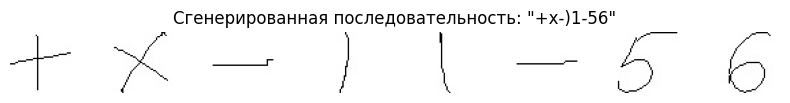

Обрабатываем последовательность: '+x-)1-56'


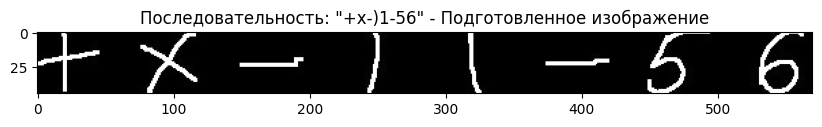

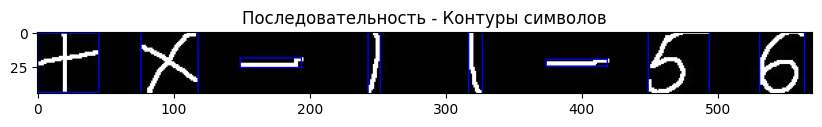

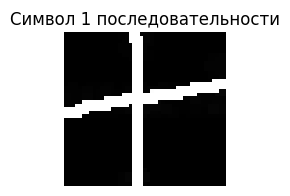

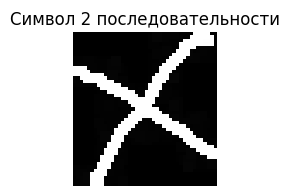

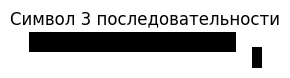

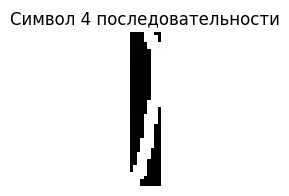

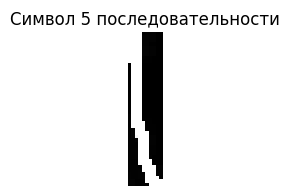

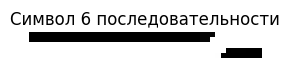

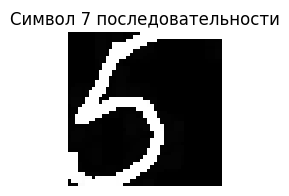

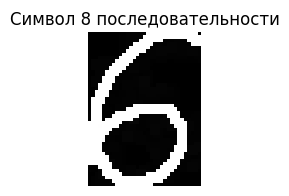

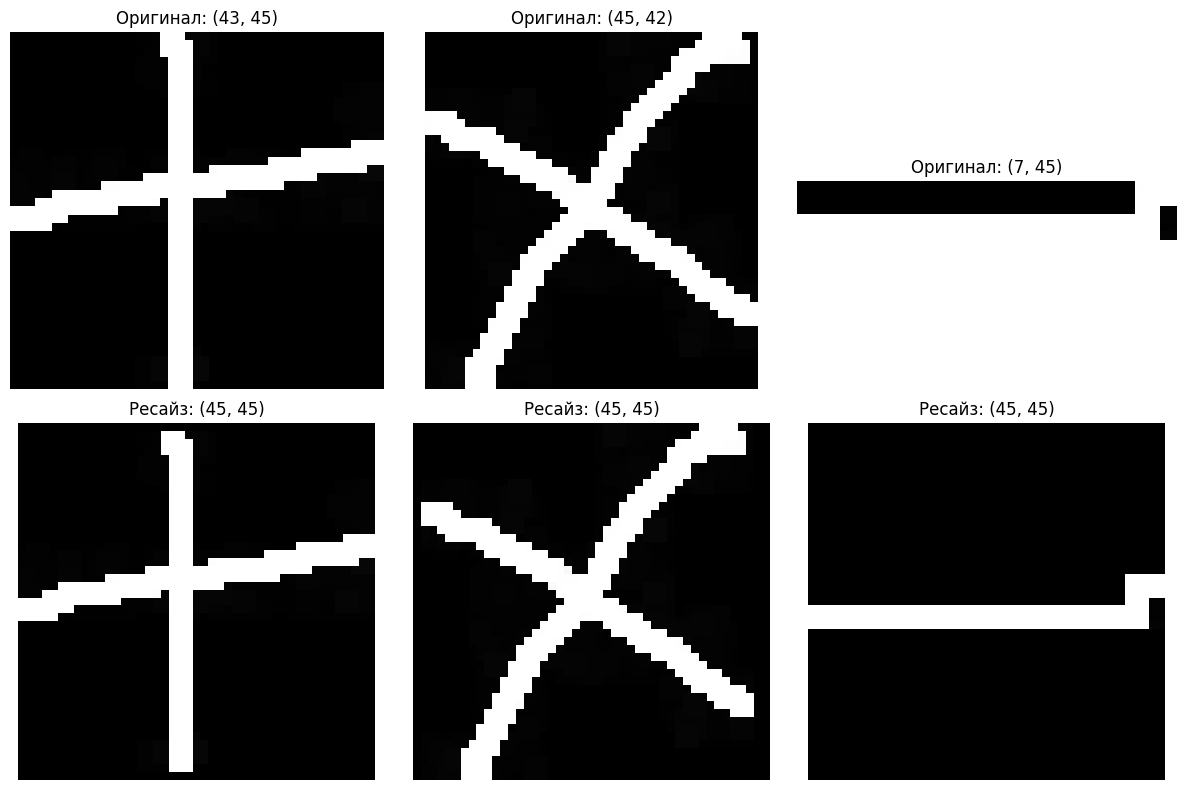

In [2]:
def create_sequence_image(images, spacing=20):
    total_width = sum(img.shape[1] for img in images) + spacing * (len(images) - 1)
    max_height = max(img.shape[0] for img in images)

    sequence_img = np.ones((max_height, total_width), dtype=np.uint8) * 255

    x_offset = 0
    for img in images:
        h, w = img.shape
        y_offset = (max_height - h)
        sequence_img[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w + spacing

    return sequence_img
sequence, images = generator.generate_sequence(length=8)
sequence_image = create_sequence_image(images, spacing=30)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.imshow(sequence_image, cmap='gray')
ax.set_title(f'Сгенерированная последовательность: "{sequence}"')
ax.axis('off')

plt.tight_layout()
plt.show()
all_data_img = []

print(f"Обрабатываем последовательность: '{sequence}'")

img_gray = sequence_image
kernel = np.ones((3,3),np.uint8)
img_gray = cv2.erode(img_gray,kernel,iterations = 1)
img_gray = cv2.bitwise_not(img_gray)
base_size=img_gray.shape[0],img_gray.shape[1]
base=np.zeros(base_size,dtype=np.uint8)
base[0:img_gray.shape[0],0:img_gray.shape[1]]=img_gray
base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)

img_rgb = base

plt.figure(figsize=(10, 3))
plt.imshow(img_rgb)
plt.title(f'Последовательность: "{sequence}" - Подготовленное изображение')
plt.show()

ret,thresh = cv2.threshold(img_rgb,127,255,0)
thresh = np.uint8(thresh)

contours, h = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
crops = []

contours_sorted = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])

for i in range(len(contours_sorted)):
    cnt = contours_sorted[i] 
    area = cv2.contourArea(cnt)
    x,y,w,h = cv2.boundingRect(cnt)
    while (w>45):
        w-=1

    if w*h > 50:
        cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(0,0,255),1)
        crops.append([x,y,w,h]) 

plt.figure(figsize=(10, 3))
plt.imshow(img_rgb)
plt.title(f'Последовательность - Контуры символов')
plt.show()

sequence_symbols = []
for i in range(len(crops)):
    x,y,w,h = crops[i]

    img_crop = img_gray[y:y+h, x:x+w]
    base = img_crop.copy()

    plt.figure(figsize=(3, 2))
    plt.imshow(base, cmap="gray")
    plt.title(f'Символ {i+1} последовательности')
    plt.axis('off')
    sequence_symbols.append((x, base))
    plt.show()

all_data_img.append({
    'sequence_text': sequence,
    'symbols': sequence_symbols
})
def center_in_45(image, target_size=45):
    h, w = image.shape

    squared = np.zeros((target_size, target_size), dtype=np.uint8)

    y_offset = (target_size - h) // 2
    x_offset = (target_size - w) // 2

    squared[y_offset:y_offset+h, x_offset:x_offset+w] = image
    return squared

all_data_img_45 = []

seq_data = all_data_img[0]
sequence_text = seq_data['sequence_text']
symbols_data = seq_data['symbols']

symbols_sorted = sorted(symbols_data, key=lambda item: item[0])

resized_symbols = []
for x, symbol_img in symbols_sorted: 
    original_size = symbol_img.shape
    resized_img = center_in_45(symbol_img)
    resized_symbols.append((x, resized_img))

all_data_img_45.append({
    'sequence_text': sequence_text,
    'symbols': resized_symbols 
})

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(min(3, len(all_data_img_45[0]['symbols']))):
    orig_img = all_data_img[0]['symbols'][i][1]
    resized_img = all_data_img_45[0]['symbols'][i][1]

    axes[0, i].imshow(orig_img, cmap='gray')
    axes[0, i].set_title(f'Оригинал: {orig_img.shape}')
    axes[0, i].axis('off')

    axes[1, i].imshow(resized_img, cmap='gray')
    axes[1, i].set_title(f'Ресайз: {resized_img.shape}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

ПОДГОТОВКА ОБУЧАЮЩЕЙ ВЫБОРКИ
Старт подготовки данных из каталога: C:\Users\user\Downloads\data
  Обрабатывается символ '0'  -> загружено 5531 изображений
  Обрабатывается символ '1'  -> загружено 21216 изображений
  Обрабатывается символ '2'  -> загружено 20912 изображений
  Обрабатывается символ '3'  -> загружено 8727 изображений
  Обрабатывается символ '4'  -> загружено 5916 изображений
  Обрабатывается символ '5'  -> загружено 2836 изображений
  Обрабатывается символ '6'  -> загружено 2494 изображений
  Обрабатывается символ '7'  -> загружено 2327 изображений
  Обрабатывается символ '8'  -> загружено 2454 изображений
  Обрабатывается символ '9'  -> загружено 502 изображений
  Обрабатывается символ '+'  -> загружено 20089 изображений
  Обрабатывается символ '-'  -> загружено 27197 изображений
  Обрабатывается символ 'times'  -> загружено 2600 изображений
  Обрабатывается символ 't'  -> загружено 2619 изображений
  Обрабатывается символ 'X'  -> загружено 21275 изображений
  Обрабатыва

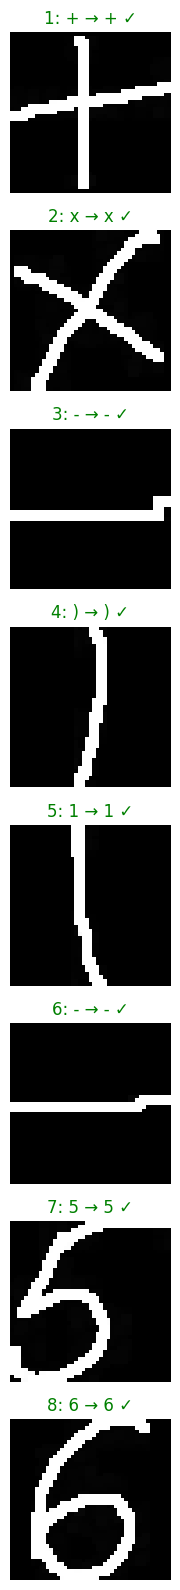

  ИТОГОВАЯ СТРОКА: '+x-)1-56' → '+x-)1-56'
  Точность: 100.00% (8/8)

--- Модель k3 ---
  Символ 1: '+' → '+' ✓
  Символ 2: 'x' → 'x' ✓
  Символ 3: '-' → '-' ✓
  Символ 4: ')' → ')' ✓
  Символ 5: '1' → '1' ✓
  Символ 6: '-' → '-' ✓
  Символ 7: '5' → '5' ✓
  Символ 8: '6' → '6' ✓


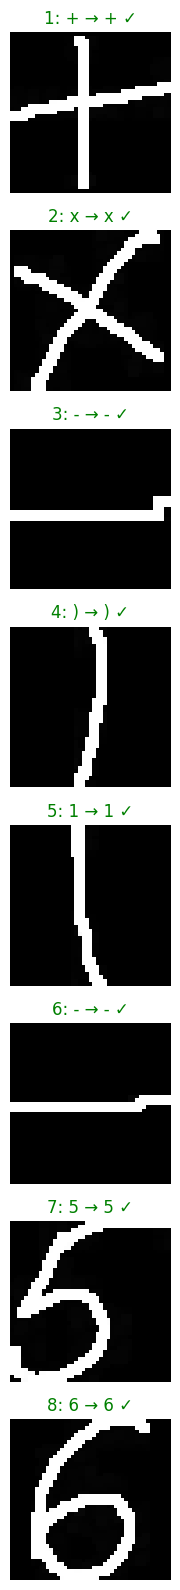

  ИТОГОВАЯ СТРОКА: '+x-)1-56' → '+x-)1-56'
  Точность: 100.00% (8/8)

--- Модель k5 ---
  Символ 1: '+' → '+' ✓
  Символ 2: 'x' → 'x' ✓
  Символ 3: '-' → '-' ✓
  Символ 4: ')' → '1' ✗
  Символ 5: '1' → '1' ✓
  Символ 6: '-' → '-' ✓
  Символ 7: '5' → '5' ✓
  Символ 8: '6' → '6' ✓


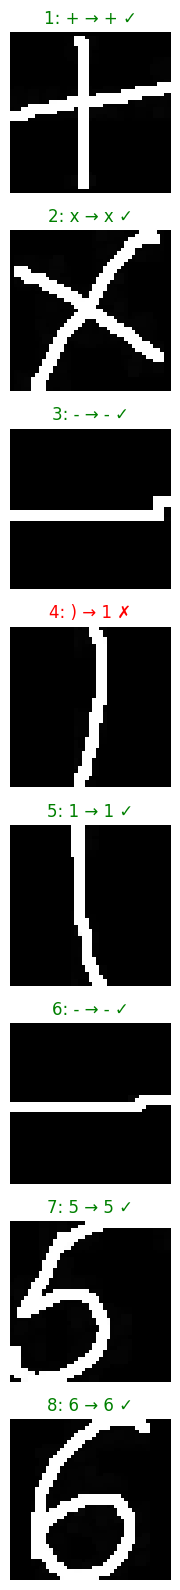

  ИТОГОВАЯ СТРОКА: '+x-)1-56' → '+x-11-56'
  Точность: 87.50% (7/8)

--- Модель k7 ---
  Символ 1: '+' → '+' ✓
  Символ 2: 'x' → '*' ✗
  Символ 3: '-' → '-' ✓
  Символ 4: ')' → '1' ✗
  Символ 5: '1' → '1' ✓
  Символ 6: '-' → '-' ✓
  Символ 7: '5' → '5' ✓
  Символ 8: '6' → '6' ✓


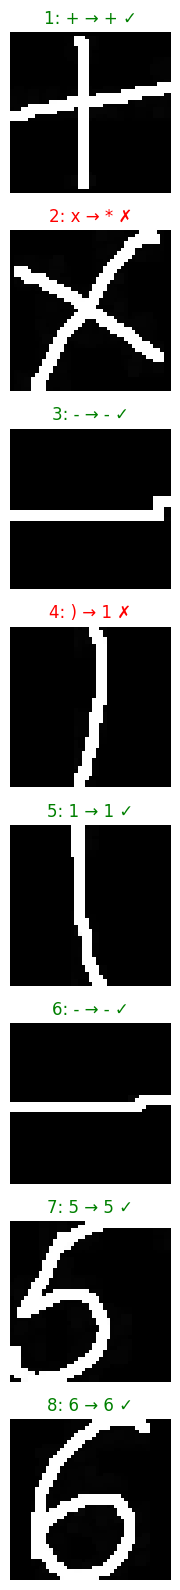

  ИТОГОВАЯ СТРОКА: '+x-)1-56' → '+*-11-56'
  Точность: 75.00% (6/8)

СВОДНЫЙ ОТЧЁТ ПО ВСЕМ ПОСЛЕДОВАТЕЛЬНОСТЯМ

 ОБОБЩЁННАЯ СТАТИСТИКА:
----------------------------------------------------------------------
k1    | Средняя: 100.00% | Лучшая: 100.00% | Худшая: 100.00%
       | Общая точность: 100.00% | Правильно: 8/8
       --------------------------------------------------
k3    | Средняя: 100.00% | Лучшая: 100.00% | Худшая: 100.00%
       | Общая точность: 100.00% | Правильно: 8/8
       --------------------------------------------------
k5    | Средняя: 87.50% | Лучшая: 87.50% | Худшая: 87.50%
       | Общая точность: 87.50% | Правильно: 7/8
       --------------------------------------------------
k7    | Средняя: 75.00% | Лучшая: 75.00% | Худшая: 75.00%
       | Общая точность: 75.00% | Правильно: 6/8
       --------------------------------------------------

 ЛУЧШАЯ МОДЕЛЬ: k1
   Средняя точность: 100.00%

РЕЗУЛЬТАТЫ ЛУЧШЕЙ МОДЕЛИ (k1)


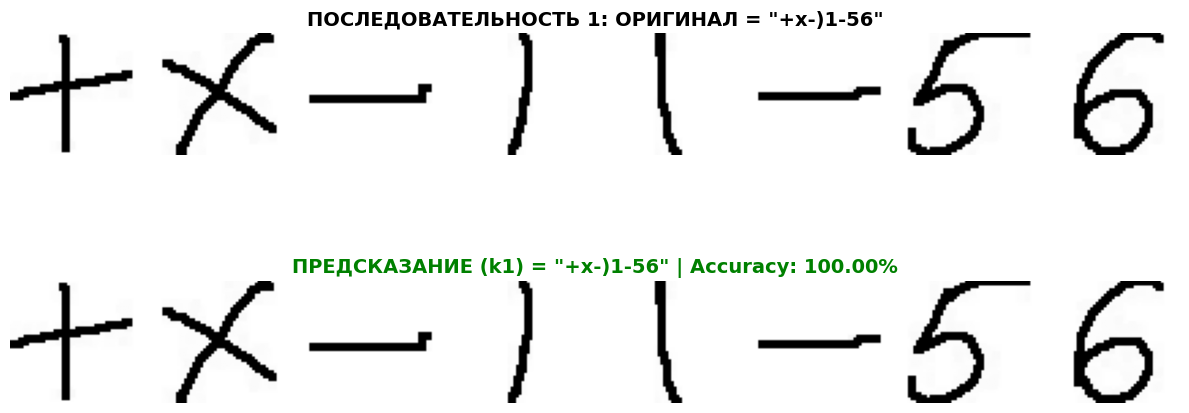


Последовательность 1:
  Оригинальный текст: '+x-)1-56'
  Предсказанный текст: '+x-)1-56'
  Точность: 100.00%


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# ----------------------------------------------------------
# Загрузка обучающих данных
# ----------------------------------------------------------

def prepare_training_data(base_dir, symbol_list, train_ratio=0.7):
    """
    base_dir     : корень с подпапками по символам
    symbol_list  : список подпапок / меток
    train_ratio  : доля изображений, используемая для обучения
    """
    X_train, y_train = [], []

    print(f"Старт подготовки данных из каталога: {base_dir}")
    total_images = 0

    for sym in symbol_list:
        sym_dir = os.path.join(base_dir, sym)
        print(f"  Обрабатывается символ '{sym}'", end="")

        if not os.path.isdir(sym_dir):
            print("  -> папки нет, пропуск")
            continue

        # получаем список файлов
        file_names = [
            f for f in os.listdir(sym_dir)
            if os.path.isfile(os.path.join(sym_dir, f))
        ]
        file_names.sort()

        if not file_names:
            print("  -> нет изображений, пропуск")
            continue

        # разбиваем на обучающую часть
        split_idx = int(len(file_names) * train_ratio)
        train_files = file_names[:split_idx]

        count_for_symbol = 0

        for fname in train_files:
            fpath = os.path.join(sym_dir, fname)
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            X_train.append(img.flatten())

            # нормализуем некоторые метки
            label = sym
            if sym == 'X':
                label = 'x'
            elif sym == 'times':
                label = '*'

            y_train.append(label)
            count_for_symbol += 1
            total_images += 1

        print(f"  -> загружено {count_for_symbol} изображений")

    print(f"Готово. Всего загружено {total_images} обучающих образцов.")
    return np.asarray(X_train), np.asarray(y_train)


# ----------------------------------------------------------
# Загрузка данных и обучение моделей k-NN
# ----------------------------------------------------------

print("=" * 50)
print("ПОДГОТОВКА ОБУЧАЮЩЕЙ ВЫБОРКИ")
print("=" * 50)

symbols = ['0','1','2','3','4','5','6','7','8','9',
           '+','-','times','t','X','y','w','h','(',')',',']

X_train, y_train = prepare_training_data(
    base_dir=r'C:\Users\user\Downloads\data',
    symbol_list=symbols,
    train_ratio=0.8
)

print(f"Размер обучающей выборки: {len(X_train)} изображений")

print("\n" + "=" * 50)
print("ОБУЧЕНИЕ МОДЕЛЕЙ K-NN")
print("=" * 50)

knn1 = KNeighborsClassifier(n_neighbors=1)
knn3 = KNeighborsClassifier(n_neighbors=3)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn7 = KNeighborsClassifier(n_neighbors=7)

print("Обучение k-NN с k=1 ...")
knn1.fit(X_train, y_train)
print("  Модель с k=1 обучена.")

print("Обучение k-NN с k=3 ...")
knn3.fit(X_train, y_train)
print("  Модель с k=3 обучена.")

print("Обучение k-NN с k=5 ...")
knn5.fit(X_train, y_train)
print("  Модель с k=5 обучена.")

print("Обучение k-NN с k=7 ...")
knn7.fit(X_train, y_train)
print("  Модель с k=7 обучена.")


# ----------------------------------------------------------
# Функция предсказания символа по картинке
# ----------------------------------------------------------

def classify_symbol(model, img_gray):
    """
    model    : обученная k-NN модель
    img_gray : изображение символа (градации серого)
    """
    inv_img = cv2.bitwise_not(img_gray)
    flat = inv_img.flatten()
    pred = model.predict([flat])
    return pred[0]


# ----------------------------------------------------------
# Тестирование на наборе последовательностей
# ----------------------------------------------------------

print("\n" + "=" * 60)
print("ТЕСТ НА НАБОРЕ ПОСЛЕДОВАТЕЛЬНОСТЕЙ")
print("=" * 60)

if 'all_data_img_45' in globals() and len(all_data_img_45) > 0:
    all_results = []

    print(f"Количество последовательностей: {len(all_data_img_45)}")

    # словарь всех моделей
    models = {
        'k1': knn1,
        'k3': knn3,
        'k5': knn5,
        'k7': knn7
    }

    # перебираем все последовательности
    for seq_idx, seq_data in enumerate(all_data_img_45):
        original_text = seq_data['sequence_text']
        symbols_data = seq_data['symbols']  # список (x, image)

        print("\n" + "=" * 60)
        print(f"ПОСЛЕДОВАТЕЛЬНОСТЬ {seq_idx + 1}/{len(all_data_img_45)}: '{original_text}'")
        print("=" * 60)

        seq_stats = {}

        # для каждой модели делаем предсказания
        for model_name, model in models.items():
            print(f"\n--- Модель {model_name} ---")
            predicted_sequence = []

            # >>> ВЕРТИКАЛЬНОЕ РАСПОЛОЖЕНИЕ СИМВОЛОВ <<<
            fig, axes = plt.subplots(
                len(symbols_data),
                1,
                figsize=(4, max(2 * len(symbols_data), 4))
            )

            # если всего один символ — делаем axes списком
            if len(symbols_data) == 1:
                axes = [axes]

            for j, (x_coord, symbol_img) in enumerate(symbols_data):
                pred_char = classify_symbol(model, symbol_img)
                predicted_sequence.append(pred_char)

                axes[j].imshow(symbol_img, cmap='gray')
                true_char = original_text[j] if j < len(original_text) else '?'
                ok = (true_char == pred_char)
                status = "✓" if ok else "✗"
                color = "green" if ok else "red"
                axes[j].set_title(
                    f"{j+1}: {true_char} → {pred_char} {status}",
                    color=color
                )
                axes[j].axis('off')

                print(f"  Символ {j+1}: '{true_char}' → '{pred_char}' {status}")

            plt.tight_layout()
            plt.show()

            predicted_text = ''.join(predicted_sequence)
            correct_chars = sum(1 for a, b in zip(original_text, predicted_text) if a == b)
            total_chars = len(original_text)
            accuracy = correct_chars / total_chars if total_chars > 0 else 0.0

            print(f"  ИТОГОВАЯ СТРОКА: '{original_text}' → '{predicted_text}'")
            print(f"  Точность: {accuracy:.2%} ({correct_chars}/{total_chars})")

            seq_stats[model_name] = {
                'predicted_text': predicted_text,
                'accuracy': accuracy,
                'correct_chars': correct_chars,
                'total_chars': total_chars
            }

        all_results.append({
            'sequence': original_text,
            'results': seq_stats
        })

    # ------------------------------------------------------
    # Сводный отчёт по моделям
    # ------------------------------------------------------
    print("\n" + "=" * 80)
    print("СВОДНЫЙ ОТЧЁТ ПО ВСЕМ ПОСЛЕДОВАТЕЛЬНОСТЯМ")
    print("=" * 80)

    model_stats = {}

    for model_name in models.keys():
        acc_list = [seq['results'][model_name]['accuracy'] for seq in all_results]
        total_correct = sum(seq['results'][model_name]['correct_chars'] for seq in all_results)
        total_chars = sum(seq['results'][model_name]['total_chars'] for seq in all_results)

        model_stats[model_name] = {
            'avg_accuracy': float(np.mean(acc_list)) if acc_list else 0.0,
            'min_accuracy': float(np.min(acc_list)) if acc_list else 0.0,
            'max_accuracy': float(np.max(acc_list)) if acc_list else 0.0,
            'total_accuracy': (total_correct / total_chars) if total_chars > 0 else 0.0,
            'total_correct': total_correct,
            'total_chars': total_chars
        }

    print("\n ОБОБЩЁННАЯ СТАТИСТИКА:")
    print("-" * 70)

    sorted_stats = sorted(
        model_stats.items(),
        key=lambda item: item[1]['avg_accuracy'],
        reverse=True
    )

    for model_name, stats in sorted_stats:
        print(f"{model_name:5} | Средняя: {stats['avg_accuracy']:6.2%} | "
              f"Лучшая: {stats['max_accuracy']:6.2%} | Худшая: {stats['min_accuracy']:6.2%}")
        print(f"       | Общая точность: {stats['total_accuracy']:6.2%} | "
              f"Правильно: {stats['total_correct']}/{stats['total_chars']}")
        print("       " + "-" * 50)

    # ------------------------------------------------------
    # Визуализация результатов лучшей модели
    # ------------------------------------------------------
    best_model_name = sorted_stats[0][0]
    best_stats = sorted_stats[0][1]

    print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
    print(f"   Средняя точность: {best_stats['avg_accuracy']:.2%}")

    print("\n" + "=" * 80)
    print(f"РЕЗУЛЬТАТЫ ЛУЧШЕЙ МОДЕЛИ ({best_model_name})")
    print("=" * 80)

    for seq_idx, seq_data in enumerate(all_data_img_45):
        original_text = seq_data['sequence_text']
        symbols_data = seq_data['symbols']

        best_model = models[best_model_name]
        predicted_symbols = [
            classify_symbol(best_model, img)
            for (x_coord, img) in symbols_data
        ]
        predicted_text = ''.join(predicted_symbols)

        accuracy = all_results[seq_idx]['results'][best_model_name]['accuracy']

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

        # Оригинальная последовательность
        original_sequence_img = create_sequence_image(
            [cv2.bitwise_not(img) for x_coord, img in symbols_data],
            spacing=10
        )
        ax1.imshow(original_sequence_img, cmap='gray')
        ax1.set_title(
            f'ПОСЛЕДОВАТЕЛЬНОСТЬ {seq_idx + 1}: ОРИГИНАЛ = "{original_text}"',
            fontsize=14,
            fontweight='bold'
        )
        ax1.axis('off')

        # Предсказанная последовательность
        ax2.imshow(original_sequence_img, cmap='gray')
        ax2.set_title(
            f'ПРЕДСКАЗАНИЕ ({best_model_name}) = "{predicted_text}" | Accuracy: {accuracy:.2%}',
            fontsize=14,
            fontweight='bold',
            color=('green' if accuracy == 1.0 else
                   'orange' if accuracy >= 0.7 else
                   'red')
        )
        ax2.axis('off')

        # Цвет рамки в зависимости от точности
        border_color = 'green' if accuracy == 1.0 else 'orange' if accuracy >= 0.7 else 'red'
        for ax in (ax1, ax2):
            for spine in ax.spines.values():
                spine.set_edgecolor(border_color)
                spine.set_linewidth(3)

        plt.tight_layout()
        plt.show()

        print(f"\nПоследовательность {seq_idx + 1}:")
        print(f"  Оригинальный текст: '{original_text}'")
        print(f"  Предсказанный текст: '{predicted_text}'")
        print(f"  Точность: {accuracy:.2%}")

else:
    print("Нет данных для тестирования последовательностей!")
    print("Проверьте, что переменная all_data_img_45 существует и содержит элементы.")
